## Testing; what happens if all Weights & Biases are initialized to zero?

In [80]:
# Split up the dataset randomly into 80% train set, 10% dev set, 10% test set.
# Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?
import random # shuffle the list of words to get an even distribution
import torch

words = open('../names.txt', 'r').read().splitlines()
random.seed(230)
random.shuffle(words)


In [81]:
# Map the words to indexes
chars = sorted(list(set(''.join(words)))) # get the unique characters through the set() method
stoi = {s:i +1 for i,s in enumerate(chars)} # string to index
stoi['.'] = 0 # end character

itos = {i:s for s,i in stoi.items()} # index to string
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [82]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  xs, ys = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      xs.append(context)
      ys.append(ix)
      context = context[1:] + [ix] # crop and append

  xs = torch.tensor(xs)
  ys = torch.tensor(ys)
  return xs, ys

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

In [104]:
## SET UP MODEL PARAMETERS

import torch.nn.functional as F

gain = 5/3 # we need a gain because we are using the tanh activation function; squashes, add a gain to get back to normal std
dim_emb = 2 # dimensionality of the embedding
n_hidden = 100 # number of hidden units

# set up the model drivers
g = torch.Generator().manual_seed(2147483648)
emb_lookup = torch.randn((len(chars) + 1, dim_emb), generator=g) #also written as 'C'. Can scale up dimensionality to capture more nuanced patterns
W1 = torch.zeros(dim_emb * block_size, n_hidden) * (gain / (dim_emb * block_size) **0.5) 
W2 = torch.zeros(n_hidden, len(chars) + 1) * (gain / n_hidden**0.5)
b2 = torch.zeros(len(chars) + 1) * 0

bngain = torch.ones((1, n_hidden)) # scale
bnbias = torch.zeros((1, n_hidden)) # shift
bnmean_running = torch.zeros((1, n_hidden)) # running mean
bnstd_running = torch.ones((1, n_hidden)) # running std

# put all of the parameters in one array for neatness -- you can sum all these to get total param count
parameters = [emb_lookup, W1, W2, b2, bngain, bnbias]

# map parameters to names
named_parameters = [
    ('emb_lookup', emb_lookup), 
    ('W1', W1), 
    ('W2', W2), 
    ('b2', b2), 
    ('bngain', bngain), 
    ('bnbias', bnbias)
]

for p in parameters:
    p.requires_grad = True

In [94]:
emb_lookup

tensor([[-1.8466,  1.1186],
        [-0.1104,  0.8080],
        [ 1.1208,  0.6045],
        [-0.2629, -0.8401],
        [-1.2115,  1.5081],
        [-0.3306, -0.3676],
        [ 0.4935, -1.0824],
        [-1.1730, -0.0739],
        [-0.3131, -0.1387],
        [ 0.0370, -0.1308],
        [ 0.3529,  0.4702],
        [-0.3813, -1.2174],
        [-0.9630,  0.1225],
        [-0.0106,  1.3502],
        [ 0.0903,  0.9139],
        [ 1.0598, -1.1161],
        [-0.2989, -0.1344],
        [-1.3220, -0.4518],
        [-0.5018,  0.5162],
        [-0.7952,  1.0163],
        [-0.5378,  1.3582],
        [ 0.2305, -2.1728],
        [ 1.4393,  0.3626],
        [-1.6578,  0.1090],
        [ 0.4156, -0.9011],
        [-0.7543,  0.3030],
        [-2.1870, -0.6238]], requires_grad=True)

In [100]:
max_steps = 20
loss_values = []
learning_rates = []
steps = []

In [105]:
## TRAINING THE MODEL

# Basically the same thing as running a validation / test run except with gradient updates
for k in range(max_steps): #running a loop as we're running a bunch of forward passes to get loss and optimize
    ## Make a mini batch
    # In this example, we will grab 32 rows of the lookup table
    # This is random, which can help with generalization
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    ## Forward pass
    # embed the input xs tensor into the lookup table
    # instead of grabbing the entire dataset as one batch to train, we get mini batches
    xs_embeddings = emb_lookup[Xtr[ix]] # feed into the two subsequent layers
    ### Batch Normalization Layer

    # standardizing these so that they are roughly gaussian before tanh
    # guassian distribution: inherantly lower probability of extreme values
    # should only be forced to be gaussian at intialization, not during training -- we want distribution to be able to move around
    # so we introduce 'scale' and 'shift' parameters to the network
    pre_activations = xs_embeddings.view(-1, 6) @  W1
    print(f'Preactivations: {pre_activations}')
    # define a forward hook that captures the outputs of intermediate layers

    # estimate batch statistics as we go so that we can pass one input through easily during val later
    bnmeani = pre_activations.mean(0, keepdim=True)
    bnstdi = pre_activations.std(0, keepdim=True)
    print(f'Batch Mean: {bnmeani}')
    print(f'Batch STD: {bnstdi}')

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani # nudging a bit toward current batch
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi # no_grad as we aren't edting activations wrt these

    pre_activations = bngain * (pre_activations - bnmeani) / bnstdi + bnbias
    

    # continue feeding into the subsequent layers
    hidden_layer = torch.tanh(pre_activations)
    logits = hidden_layer @ W2 + b2 #matrix multiplication, give us the log counts
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())

    # TODO: need to understand the L2 regularization from part one. Also less clear about functions below
    # For example: 1) why are we going through all the parameters, and 2) why aren't we updating weights.data, but all

    ## Backward pass   
    for p in parameters:
        p.grad = None
    loss.backward()

    ## Inspect the gradients
    '''
    for name, p in named_parameters:
        if p.grad is not None:
            print(f'{name} grad: {p.grad}')
        else:
            print(f'{name} has no grad yet')
    '''
            
    ## Update
    for p in parameters:
        p.data += -(0.003) * p.grad
    steps.append(k)
    loss_values.append(loss.log10().item())   
    

tensor([[[-0.7952,  1.0163],
         [-0.7543,  0.3030],
         [ 0.0903,  0.9139]],

        [[-0.7952,  1.0163],
         [-0.3131, -0.1387],
         [-0.1104,  0.8080]],

        [[ 0.0370, -0.1308],
         [-0.7543,  0.3030],
         [-0.1104,  0.8080]],

        [[-1.8466,  1.1186],
         [-1.8466,  1.1186],
         [-1.8466,  1.1186]],

        [[ 0.0370, -0.1308],
         [ 0.0903,  0.9139],
         [-0.1104,  0.8080]],

        [[-1.8466,  1.1186],
         [-1.8466,  1.1186],
         [-0.7952,  1.0163]],

        [[-1.8466,  1.1186],
         [-0.1104,  0.8080],
         [-0.3131, -0.1387]],

        [[-1.8466,  1.1186],
         [-1.8466,  1.1186],
         [-0.5378,  1.3582]],

        [[ 0.0370, -0.1308],
         [-0.7952,  1.0163],
         [-0.3131, -0.1387]],

        [[ 0.0370, -0.1308],
         [-0.7952,  1.0163],
         [-0.0106,  1.3502]],

        [[-0.9630,  0.1225],
         [ 0.0370, -0.1308],
         [-0.1104,  0.8080]],

        [[-0.1104,  0

### Observing what happens when weights and biases are set to zero
It's so interesting that some of the weights are [0, 0] and other are [nan, nan].
What exactly are these?

parameters = [emb_lookup, W1, W2, b2, bngain, bnbias]

It mostly seems like nothing is training at all?

In [ ]:
import matplotlib.pyplot as plt

# CHECK HIDDEN LAYER ACTIVATIONS
# There are many very extreme values, which will all get squashed

plt.hist(pre_activations.view(-1).tolist(), 50)

In [ ]:
# CHECK ACTIVATION FUNCTION VALUES
# This is something that goes wrong in initializing nn's - too many +-1's
# This means that inputs to the tanh are two extreme, so they are getting squashed
# As the activation function approaches +-1, the gradient (ie. derivation of the function) approaches 0
# A backward pass function: self.grad += (1-t**2) * out.grad

plt.hist(hidden_layer.view(-1).tolist(), 50)

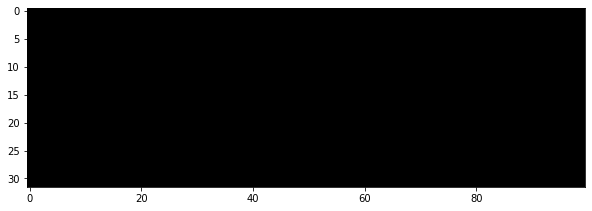

In [60]:
# PLOT HIDDEN LAYER ACTIVATIONS
# If there is an entire column of white, that means we have a dead neuron because the backward gradient was destroyed

plt.figure(figsize=(10, 10))
plt.imshow(hidden_layer.abs() > 0.99, cmap='gray', interpolation='nearest')

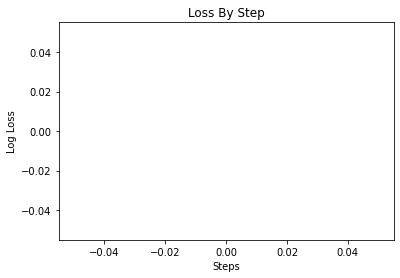

In [61]:
# PLOT STEPS TO LOSS RELATIONSHIP (Iteration Two, After Increasing Model Size)

plt.plot(steps, loss_values)
plt.title("Loss By Step")
plt.xlabel("Steps")
plt.ylabel("Log Loss")
plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

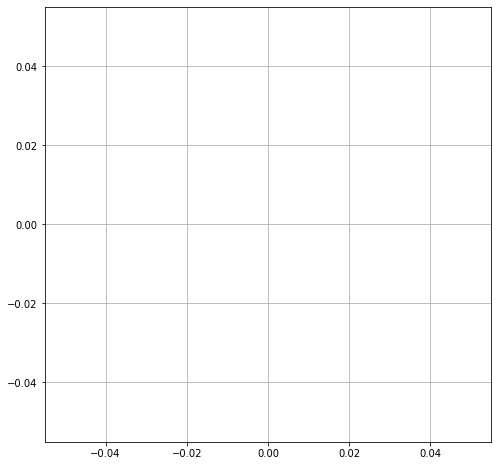

In [27]:
# PLOT EMBEDDINGS (Iteration Three)
# TODO: I don't know why this is returning embedded characters, yet.
# When characters are close to each other the neural net is treating them similarly

plt.figure(figsize=(8,8))
plt.scatter(emb_lookup[:, 0].data, emb_lookup[:,1].data, s=200) # each word has two dimensions / columns
for i in range(emb_lookup.shape[0]):
    plt.text(emb_lookup[i, 0].item(), emb_lookup[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [62]:
# CHECK TOTAL LOSS ON TRAIN_SET FORWARD PASS

# Do a forward pass (without updates)
@torch.no_grad()

def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]

    xs_embeddings = emb_lookup[x]
    pre_activations = xs_embeddings.view(xs_embeddings.shape[0], -1) @  W1 
    pre_activations = bngain * (pre_activations - bnmean_running) / bnstd_running + bnbias
    hidden_layer = torch.tanh(pre_activations)

    logits = hidden_layer @ W2 + b2 # matrix multiplication, give us the log counts
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


train nan
val nan


In [ ]:
# SAMPLE FROM MODEL

g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # Forward pass
        embeddings = emb_lookup[torch.tensor([context])]
        hidden_layer = torch.tanh(embeddings.view(1, -1) @ W1 + b1)
        logits = hidden_layer @ W2 + b2
        probs = F.softmax(logits, dim=1)

        # Sample from distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        # Shift context window and track samples
        context = context[1:] + [ix]
        out.append(ix)

        # Break if end token detected
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

mria.
mayahlieel.
ndynyal.
rethrstend.
leg.
aderedieliileli.
jelle.
eisennanar.
kayziohlara.
noshubergahi.
jest.
jair.
jelilentenof.
uba.
ghde.
jyleli.
ehs.
kay.
myskeyah.
hil.
